In [1]:
import os

import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from IPython.core.interactiveshell import InteractiveShell
from tensorflow import keras

from src.data_utils import ImageLoader, SemiHardTripletsGenerator, train_val_split
from src.utils import (
    compute_val_dcg,
    make_callbacks,
    plot_history,
    save_params,
    save_submission,
    show_heatmap,
)

InteractiveShell.ast_node_interactivity = "all"

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 64
        self.img_size = (512, 81)
        self.n_channels = None
        self.fold = 0
        self.norm = False
        self.pos_label = 0
        self.emb_len = 1024
        self.kernel_size = 3
        self.act_fn = "relu"
        self.batch_norm = True
        self.n_epochs = 150
        self.center_crop = False
        self.input_shape = (
            self.img_size
            if self.n_channels is None
            else (*self.img_size, self.n_channels)
        )


cfg = CFG()

In [3]:
cfg = CFG()

In [4]:
root_dir = "/app/_data/artist_data/"
mod_dir = f"/app/_data/artist_data/models/triple_semihard_fold_{cfg.fold}/"
os.makedirs(mod_dir, exist_ok=True)

In [5]:
train = pd.read_csv(os.path.join(root_dir, "train_meta.tsv"), sep="\t")
test = pd.read_csv(os.path.join(root_dir, "test_meta.tsv"), sep="\t")

## train_val_split

In [6]:
train_df, val_df = train_val_split(df=train, fold=2, seed=42)

## DataGenerator

In [7]:
train_gen = SemiHardTripletsGenerator(
    df=train_df,
    data_loader=ImageLoader(
        target_size=cfg.img_size,
        augment=True,
        center_crop=cfg.center_crop,
        norm=cfg.norm,
        n_channels=cfg.n_channels,
    ),
    batch_size=cfg.batch_size,
    shuffle=True,
)
val_gen = SemiHardTripletsGenerator(
    df=val_df,
    data_loader=ImageLoader(
        target_size=cfg.img_size,
        augment=True,
        center_crop=cfg.center_crop,
        norm=cfg.norm,
        n_channels=cfg.n_channels,
    ),
    batch_size=cfg.batch_size,
    shuffle=True,
)

## Model

In [8]:
def embNet(cfg):
    input = tf.keras.Input(shape=cfg.input_shape, dtype="float32")
    x = keras.layers.Conv1D(
        cfg.input_shape[0],
        cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_1",
    )(input)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[0],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_2",
    )(x)
    x = keras.layers.AveragePooling1D(pool_size=2, name="avg_pool_1")(x)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[0],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_3",
    )(x)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[0],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_4",
    )(x)
    x = keras.layers.AveragePooling1D(pool_size=2, name="avg_pool_2")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    x = keras.layers.Dense(cfg.emb_len, activation=None, name=f"dense_{cfg.emb_len}")(x)
    x = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="l2norm")(x)
    return keras.Model(inputs=input, outputs=x, name="embedding")


embedding_net = embNet(cfg)

In [10]:
embedding_net.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss()
)

In [11]:
callbacks = make_callbacks(
    path=mod_dir, monitor="val_loss", mode="min", reduce_patience=3, stop_patience=10
)

## Train

In [12]:
history = embedding_net.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=cfg.n_epochs,
    callbacks=callbacks,
    max_queue_size=10,
    workers=10,
)

Epoch 1/150
2129/2130 [============================>.] - ETA: 0s - loss: 0.8411
Epoch 1: val_loss improved from inf to 0.82642, saving model to /app/_data/artist_data/models/triple_semihard_fold_0/best.h5
2130/2130 [==============================] - 358s 166ms/step - loss: 0.8411 - val_loss: 0.8264 - lr: 0.0010
Epoch 2/150
2129/2130 [============================>.] - ETA: 0s - loss: 0.8040
Epoch 2: val_loss improved from 0.82642 to 0.80935, saving model to /app/_data/artist_data/models/triple_semihard_fold_0/best.h5
2130/2130 [==============================] - 339s 159ms/step - loss: 0.8040 - val_loss: 0.8093 - lr: 0.0010
Epoch 3/150
2130/2130 [==============================] - ETA: 0s - loss: 0.7866
Epoch 3: val_loss improved from 0.80935 to 0.80249, saving model to /app/_data/artist_data/models/triple_semihard_fold_0/best.h5
2130/2130 [==============================] - 362s 169ms/step - loss: 0.7866 - val_loss: 0.8025 - lr: 0.0010
Epoch 4/150
2129/2130 [============================>.

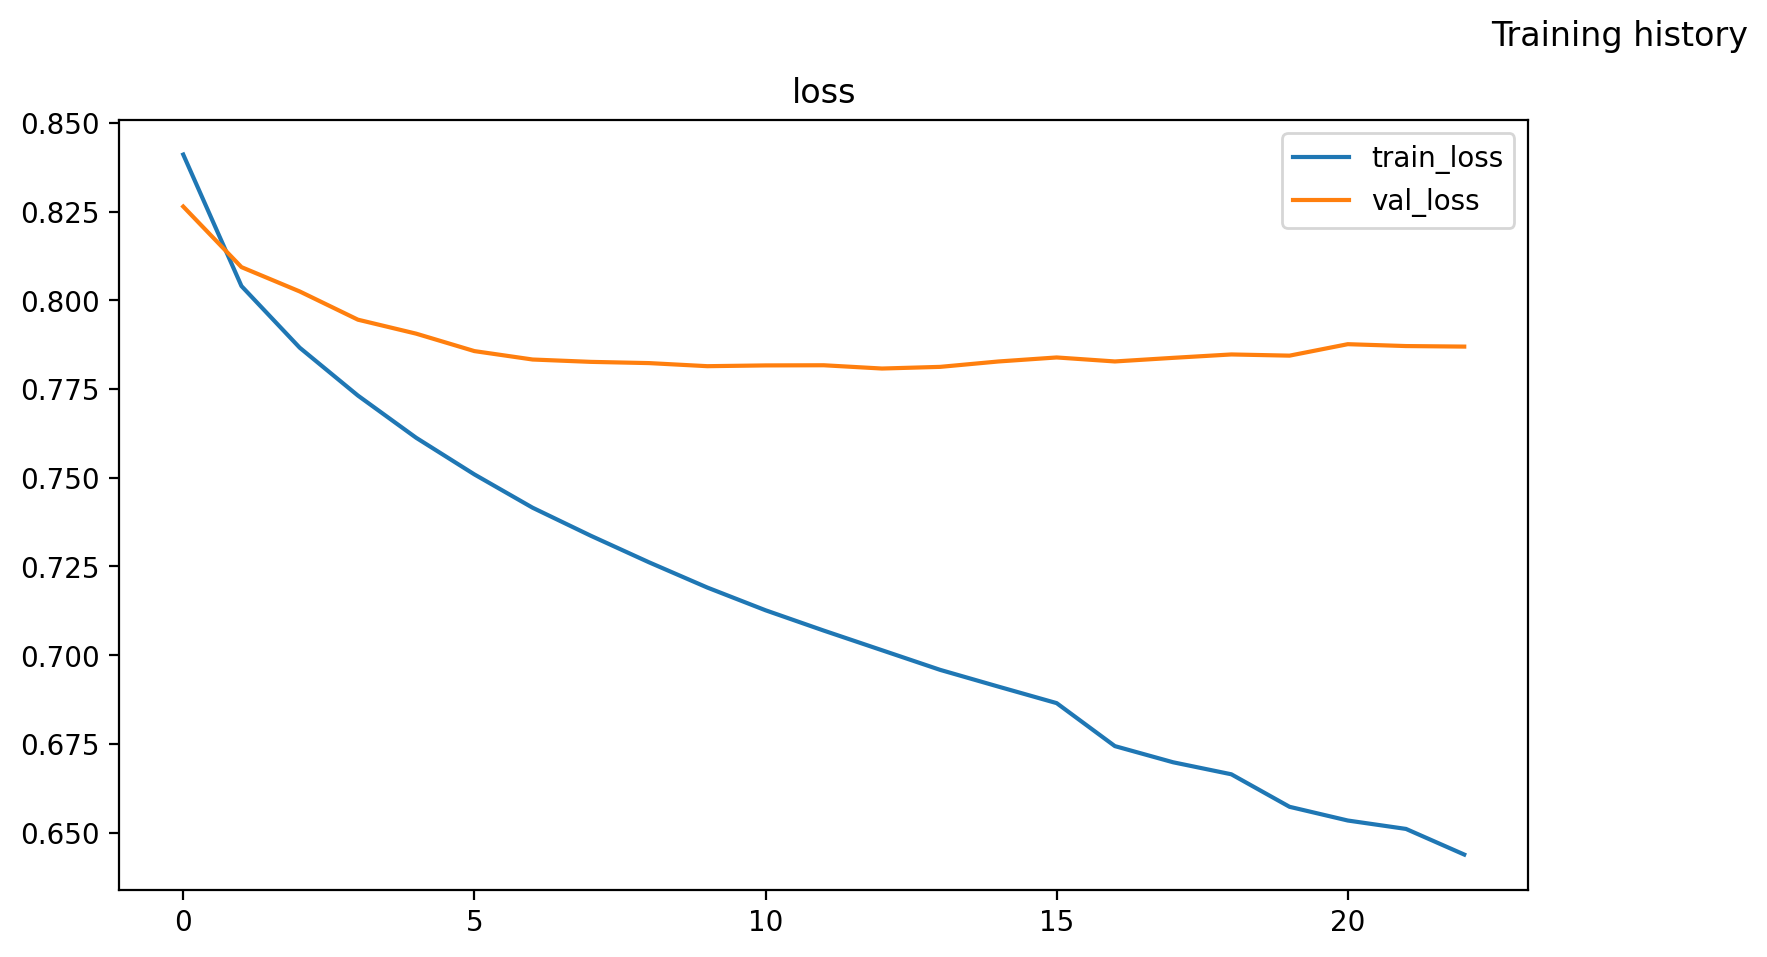

In [13]:
plot_history(history.history)

## Eval and save

In [14]:
compute_val_dcg(embedding_net, val_df, cfg, "angular")

Making prediction
20902/20902 [==============================] - 57s 3ms/step

Computing ranked list


100% 20902/20902 [00:04<00:00, 4900.25it/s]
100% 20902/20902 [00:34<00:00, 600.96it/s]



Calculating NDCG


100% 20902/20902 [00:05<00:00, 3842.48it/s]


NDCG on val set = 0.26404


300/300 [==============================] - 1s 3ms/step


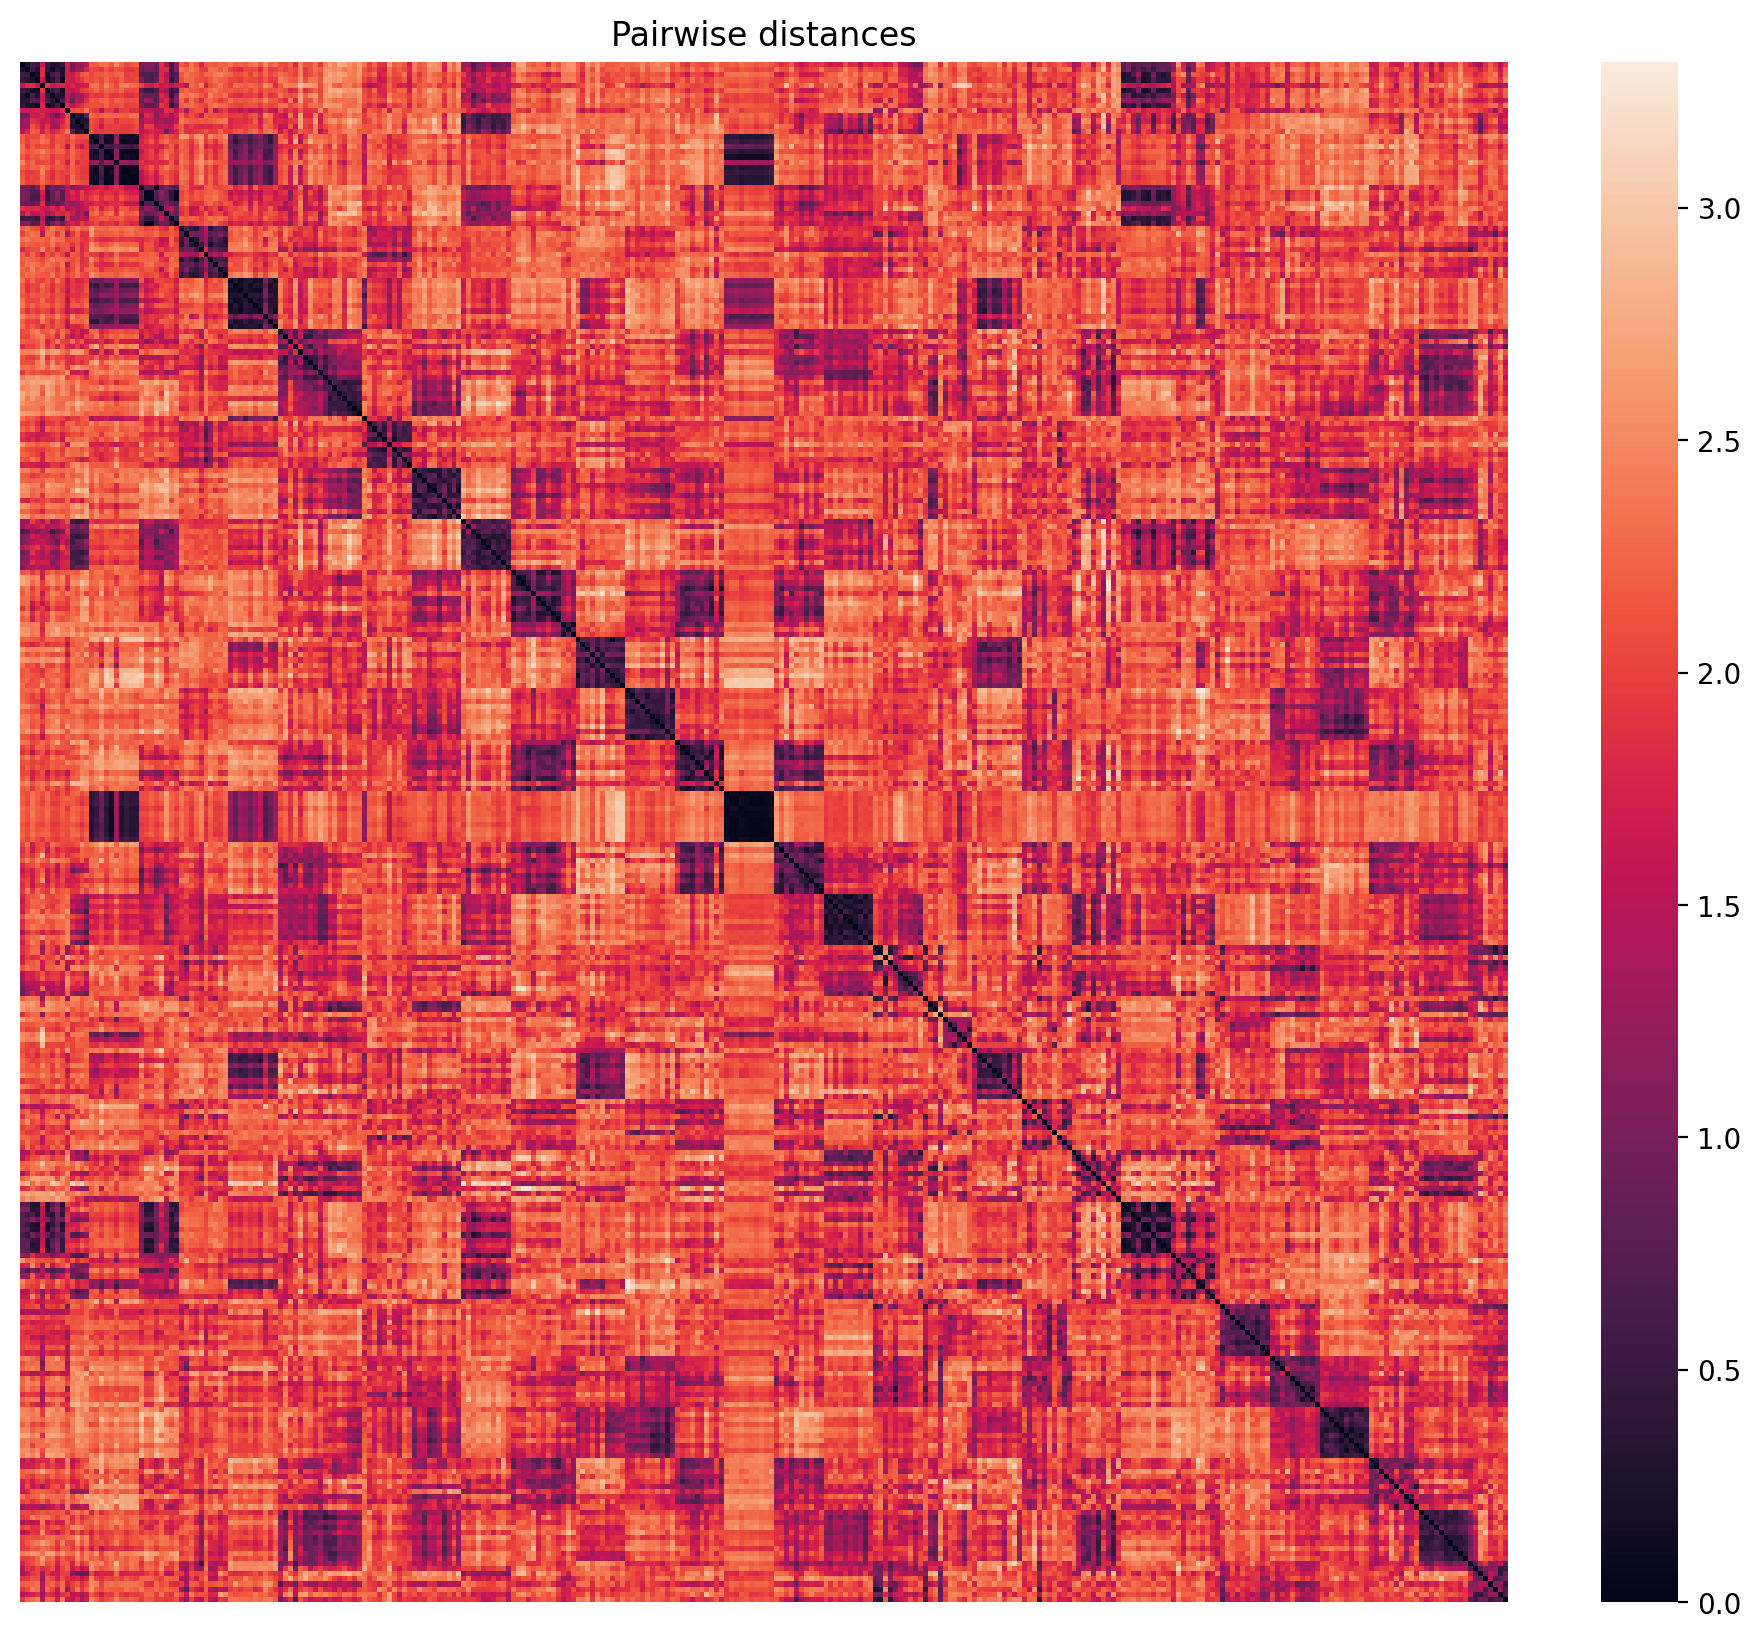

In [15]:
show_heatmap(val_df.sort_values("artistid").head(300), cfg, embedding_net)

In [16]:
save_params(
    mod_dir,
    embedding_net,
    history,
    cfg,
    loss_name="TripletSemiHardLoss",
    metric=None,
    triplets=True,
)


Min_loss = 0.7807722687721252, model saved to /app/_data/artist_data/models/triple_semihard_fold_0/model_781.h5


## Test

In [17]:
save_submission(
    model=embedding_net,
    test_df=test,
    cfg=cfg,
    submission_path=mod_dir,
    annoy_metric="euclidean",
    top_size=100,
    annoy_num_trees=256,
)

Making prediction
41377/41377 [==============================] - 112s 3ms/step

Computing ranked list


100% 41377/41377 [00:08<00:00, 4953.09it/s]
100% 41377/41377 [02:08<00:00, 321.25it/s]



Submission file saved to /app/_data/artist_data/models/triple_semihard_fold_0/submission_100.txt
